# Session 20 Assignment:

1. Use ResNet34 or ResNet18 Pre-trained model on Imagenet for CIFAR100 dataset. 
2. Describe the strategy you'd use to do this. 
3. Implement the code
4. Get at least 80% VA. https://benchmarks.ai/cifar-100 (Links to an external site.)
5. Submit

old Task is to 
* Import Resnet50 Model weights - [https://github.com/qubvel/classification_models] -- Pending
* predict on cifar10 data - [http://www.hackevolve.com/where-cnn-is-looking-grad-cam/] -- Pending
* Find 50 missclassified images
* Perform gradCAM on these 50 images

Pending: improving accuravy form 70; 

# Imports and Utils

In [1]:
!pip install image-classifiers
!pip install git+https://github.com/qubvel/classification_models.git
  
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import np_utils

     |████████████████████████████████| 81kB 10.1MB/s 
  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-kkb58tb2
  Running command git clone -q https://github.com/qubvel/classification_models.git /tmp/pip-req-build-kkb58tb2
  Running command git submodule update --init --recursive -q
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0b1-cp36-none-any.whl size=19977 sha256=01804679220bbf4ec52adadb9f11a3df25e5906c2933e75675bee492c8d30c80
  Stored in directory: /tmp/pip-ephem-wheel-cache-ea3behzq/wheels/de/2b/fd/29a6d33edb8c28bc7d94e95ea1d39c9a218ac500a3cfb1b197
Successfully built image-classifiers
  Found existing installation: image-classifiers 0.2.2
    Uninstalling image-classifiers-0.2.2:
      Successfully uninstalled image-classifiers-0.2.2


Using TensorFlow backend.


## Data

In [2]:
# prepare your data
from keras.datasets import cifar100
(train_features, train_labels), (test_features, test_labels) = cifar100.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

169009152/169001437 [==============================] - 6s 0us/step


In [3]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

print (train_labels.shape)

(50000, 100)


In [18]:
print (train_features.shape)

(50000, 32, 32, 3)


## Plot Modle Function

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

## Measure accuract

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

# Importing ResNet18 model

https://github.com/qubvel/classification_models

In [0]:
import keras
import numpy as np
from skimage.io import imread
from skimage.transform import resize
from keras.applications.imagenet_utils import decode_predictions
#from keras.applications import ResNet34

# for keras
from classification_models.keras import Classifiers

# for tensorflow.keras
# from classification_models.tfkeras import Classifiers

ResNet18, preprocess_input = Classifiers.get('resnet18')

#X = preprocess_input()
#y = 

n_classes = num_classes #10



# Resnet18 on 32x32 data

## Build model and show summary

In [0]:
# build model
base_model = ResNet18(input_shape=(32,32,3), weights='imagenet', classes=n_classes, include_top=False)

#Freezing except recent 4 layers from imported model
'''for layer in base_model.layers[:-4]:
    layer.trainable = False
'''
x = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation='softmax')(x)
model = keras.models.Model(inputs=[base_model.input], outputs=[output])

# Compile
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()








44924928/44920640 [==============================] - 1s 0us/step

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 32, 32, 3)    9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 38, 38, 3)    0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 16, 16, 64)   9408        zero_padding2d_1[0][0]           
___________________

## Image Aug and Training

### Training for first 10 epochs

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=97, epochs=10)`
  


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
97/97 [==============================] - 42s 436ms/step - loss: 4.5466 - acc: 0.0700 - val_loss: 3.9318 - val_acc: 0.1365
Epoch 2/10
97/97 [==============================] - 33s 341ms/step - loss: 3.6186 - acc: 0.1789 - val_loss: 3.3463 - val_acc: 0.2151
Epoch 3/10
97/97 [==============================] - 33s 341ms/step - loss: 3.1378 - acc: 0.2522 - val_loss: 2.9996 - val_acc: 0.2698
Epoch 4/10
97/97 [==============================] - 33s 340ms/step - loss: 2.8367 - acc: 0.3033 - val_loss: 2.7883 - val_acc: 0.3061
Epoch 5/10
97/97 [==============================] - 33s 340ms/step - loss: 2.6267 - acc: 0.3399 - val_loss: 2.6327 - val_acc: 0.3311
Epoch 6/10
97/97 [==============================] - 33s 337ms/step - loss: 2.4691 - acc: 0.3693 - val_loss: 2.5300 - val_acc: 0.3503
Epoch 7/10
97/97 [==============================] - 33s 338ms/step - loss: 2.3504 - acc: 0.3935 - val_loss: 

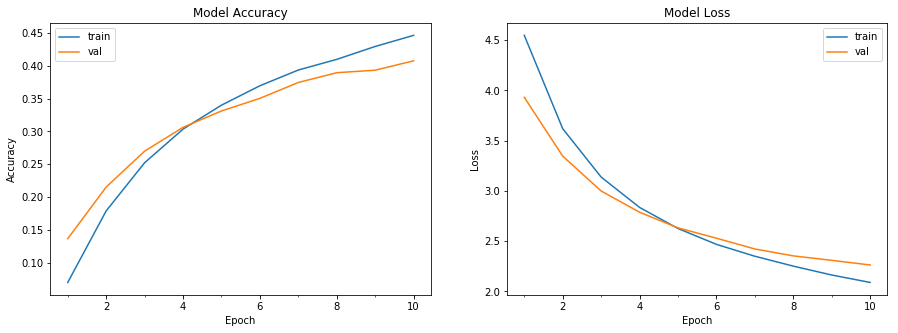

Accuracy on test data is: 40.75


In [0]:
# Train
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        rotation_range=15, width_shift_range=0.1, height_shift_range=0.1)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 512),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 10, 
                                 validation_data = (test_features, test_labels), verbose=1, 
                                 )
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

### Train for 20 more epochs; total 30

Epoch 1/20


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=97, epochs=20)`
  """


97/97 [==============================] - 34s 348ms/step - loss: 2.0315 - acc: 0.4583 - val_loss: 2.2443 - val_acc: 0.4155
Epoch 2/20
97/97 [==============================] - 33s 343ms/step - loss: 1.9721 - acc: 0.4709 - val_loss: 2.1640 - val_acc: 0.4297
Epoch 3/20
97/97 [==============================] - 33s 343ms/step - loss: 1.9185 - acc: 0.4826 - val_loss: 2.1461 - val_acc: 0.4387
Epoch 4/20
97/97 [==============================] - 33s 344ms/step - loss: 1.8876 - acc: 0.4887 - val_loss: 2.1112 - val_acc: 0.4450
Epoch 5/20
97/97 [==============================] - 33s 341ms/step - loss: 1.8321 - acc: 0.5052 - val_loss: 2.0906 - val_acc: 0.4481
Epoch 6/20
97/97 [==============================] - 33s 338ms/step - loss: 1.7873 - acc: 0.5139 - val_loss: 2.0429 - val_acc: 0.4581
Epoch 7/20
97/97 [==============================] - 33s 338ms/step - loss: 1.7569 - acc: 0.5213 - val_loss: 2.0340 - val_acc: 0.4606
Epoch 8/20
97/97 [==============================] - 33s 341ms/step - loss: 1.717

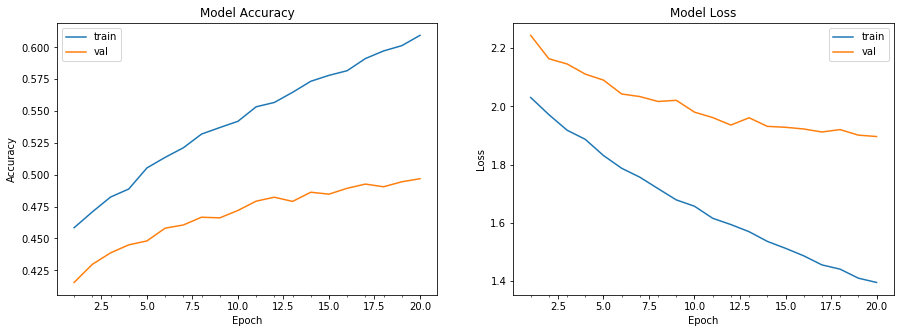

Accuracy on test data is: 49.69


In [0]:
# train the model for 20 more epochs
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 512),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 20, 
                                 validation_data = (test_features, test_labels), verbose=1, 
                                 )
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

### Train for 20 more epochs; total 50

Epoch 1/20


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=97, epochs=20)`
  """


97/97 [==============================] - 34s 349ms/step - loss: 1.3744 - acc: 0.6131 - val_loss: 1.8654 - val_acc: 0.5039
Epoch 2/20
97/97 [==============================] - 34s 347ms/step - loss: 1.3498 - acc: 0.6195 - val_loss: 1.8660 - val_acc: 0.5035
Epoch 3/20
97/97 [==============================] - 34s 347ms/step - loss: 1.3346 - acc: 0.6240 - val_loss: 1.8795 - val_acc: 0.5032
Epoch 4/20
97/97 [==============================] - 33s 342ms/step - loss: 1.3130 - acc: 0.6280 - val_loss: 1.8517 - val_acc: 0.5078
Epoch 5/20
97/97 [==============================] - 33s 339ms/step - loss: 1.2903 - acc: 0.6334 - val_loss: 1.8496 - val_acc: 0.5057
Epoch 6/20
97/97 [==============================] - 33s 340ms/step - loss: 1.2748 - acc: 0.6407 - val_loss: 1.8741 - val_acc: 0.5045
Epoch 7/20
97/97 [==============================] - 33s 344ms/step - loss: 1.2554 - acc: 0.6429 - val_loss: 1.8508 - val_acc: 0.5095
Epoch 8/20
97/97 [==============================] - 33s 345ms/step - loss: 1.231

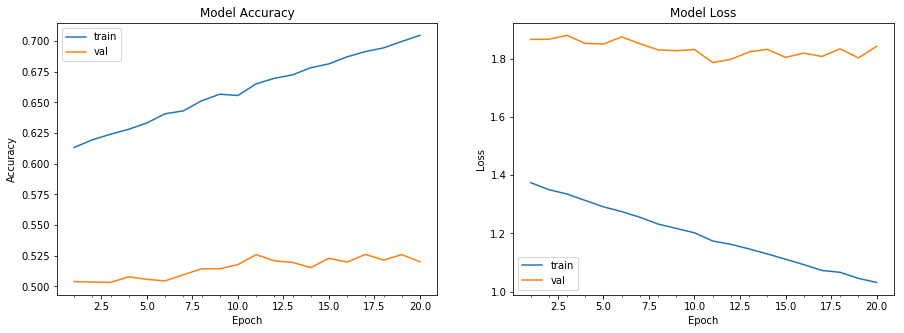

Accuracy on test data is: 52.00


In [0]:
# train the model for 20 more epochs
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 512),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 20, 
                                 validation_data = (test_features, test_labels), verbose=1, 
                                 )
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

## Prediction

In [0]:
# finding missclassifide images
y_preds = model.predict(test_features)

#misclassified = np.where(np.argmax(y_preds) != np.argmax(test_labels))
#print (np.where(np.argmax(y_preds)) != np.where(np.argmax(test_labels))

# Training post preprossing image of scaled dimention of 64x64

In [0]:
#import for this lag of experiments
import numpy as np
import cv2
from skimage.io import imread
from skimage.transform import resize
from keras.applications.imagenet_utils import decode_predictions

## Reshaping train data

In [0]:
# preparing cifar100 batches to train model
train_features1 = preprocess_input(train_features)
test_features1 = preprocess_input(test_features)

In [0]:
#Reshaping the training data
X_train_new = np.array([cv2.resize(train_features[i], (64, 64)) for i in range(0, len(train_features))]).astype('float32')

#Preprocessing the data, so that it can be fed to the pre-trained ResNet50 model. 
resnet_train_input = preprocess_input(X_train_new)

#Creating bottleneck features for the training data
train_features1 = model1.predict(resnet_train_input)

#Saving the bottleneck features
np.savez('resnet_features_train', features=train_features1)

In [20]:
print(resnet_train_input.shape)

(50000, 64, 64, 3)


## Reshaping test data

In [0]:
#Reshaping the testing data
X_test_new = np.array([cv2.resize(test_features[i], (64, 64)) for i in range(0, len(test_features))]).astype('float32')

#Preprocessing the data, so that it can be fed to the pre-trained ResNet50 model.
resnet_test_input = preprocess_input(X_test_new)

#Creating bottleneck features for the testing data
test_features1 = model1.predict(resnet_test_input)

#Saving the bottleneck features
np.savez('resnet_features_test', features=test_features1)

## Building model and printing arch of model

In [12]:
# build model
base_model1 = ResNet18(input_shape=(64,64,3), weights='imagenet', classes=n_classes, include_top=False)

x = keras.layers.GlobalAveragePooling2D()(base_model1.output)
output = keras.layers.Dense(n_classes, activation='softmax')(x)
model1 = keras.models.Model(inputs=[base_model1.input], outputs=[output])

# Compile
model1.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])
model1.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 64, 64, 3)    9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_19 (ZeroPadding2 (None, 70, 70, 3)    0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 32, 32, 64)   9408        zero_padding2d_19[0][0]          
____________________________________________________________________________________________

## Setting up basic Data aug with ImageDataGenerator

In [0]:
#Setting up basic data aug

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        rotation_range=15, width_shift_range=0.1, height_shift_range=0.1)



## Training Model

### First 10 Epochs

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=97, epochs=10)`
  """


Epoch 1/10
97/97 [==============================] - 42s 433ms/step - loss: 4.7304 - acc: 0.0697 - val_loss: 3.9847 - val_acc: 0.1663
Epoch 2/10
97/97 [==============================] - 41s 419ms/step - loss: 3.3123 - acc: 0.2395 - val_loss: 2.9006 - val_acc: 0.3140
Epoch 3/10
97/97 [==============================] - 40s 410ms/step - loss: 2.6423 - acc: 0.3575 - val_loss: 2.3904 - val_acc: 0.3984
Epoch 4/10
97/97 [==============================] - 40s 415ms/step - loss: 2.2616 - acc: 0.4235 - val_loss: 2.1242 - val_acc: 0.4484
Epoch 5/10
97/97 [==============================] - 40s 409ms/step - loss: 2.0182 - acc: 0.4721 - val_loss: 1.9073 - val_acc: 0.4939
Epoch 6/10
97/97 [==============================] - 40s 412ms/step - loss: 1.8673 - acc: 0.4985 - val_loss: 1.7779 - val_acc: 0.5191
Epoch 7/10
97/97 [==============================] - 40s 409ms/step - loss: 1.7352 - acc: 0.5274 - val_loss: 1.6996 - val_acc: 0.5360
Epoch 8/10
97/97 [==============================] - 40s 409ms/step - 

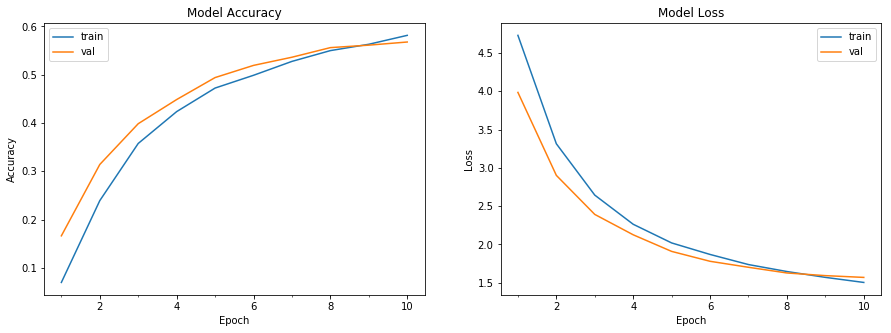

NameError: ignored

In [21]:
# train the model
start = time.time()
# Train the model
model_info = model1.fit_generator(datagen.flow(resnet_train_input, train_labels, batch_size = 512),
                                 samples_per_epoch = train_features1.shape[0], nb_epoch = 10, 
                                 validation_data = (resnet_test_input, test_labels), verbose=1, 
                                 )
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model1))

### Training for another 10 epochs; total 20 epochs

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=10)`
  """


Epoch 1/10
390/390 [==============================] - 43s 110ms/step - loss: 1.5108 - acc: 0.5767 - val_loss: 1.4303 - val_acc: 0.5990
Epoch 2/10
390/390 [==============================] - 42s 108ms/step - loss: 1.3637 - acc: 0.6134 - val_loss: 1.3650 - val_acc: 0.6106
Epoch 3/10
390/390 [==============================] - 43s 109ms/step - loss: 1.2455 - acc: 0.6430 - val_loss: 1.2779 - val_acc: 0.6346
Epoch 4/10
390/390 [==============================] - 42s 108ms/step - loss: 1.1633 - acc: 0.6601 - val_loss: 1.2322 - val_acc: 0.6477
Epoch 5/10
390/390 [==============================] - 43s 111ms/step - loss: 1.0874 - acc: 0.6811 - val_loss: 1.1767 - val_acc: 0.6613
Epoch 6/10
390/390 [==============================] - 43s 109ms/step - loss: 1.0253 - acc: 0.6989 - val_loss: 1.1725 - val_acc: 0.6640
Epoch 7/10
390/390 [==============================] - 42s 109ms/step - loss: 0.9733 - acc: 0.7134 - val_loss: 1.1532 - val_acc: 0.6686
Epoch 8/10
390/390 [==============================] - 4

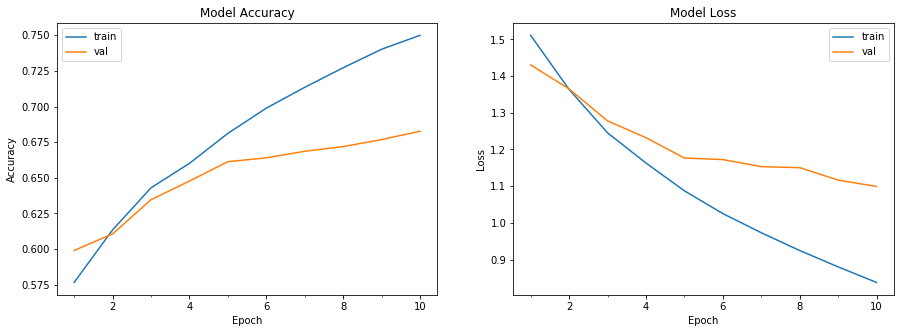

Accuracy on test data is: 68.27


In [22]:
# train the model
start = time.time()
# Train the model
model_info = model1.fit_generator(datagen.flow(resnet_train_input, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features1.shape[0], nb_epoch = 10, 
                                 validation_data = (resnet_test_input, test_labels), verbose=1, 
                                 )
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(resnet_test_input, test_labels, model1))

### Data Augmentation with cutout and training for 10 epochs

In [26]:
!git clone https://github.com/yu4u/cutout-random-erasing ./random_eraser 
import sys
sys.path.append("/content/random_eraser/")

# importing lib for cutout
from random_eraser import get_random_eraser

datagen2 = ImageDataGenerator(
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=False))

fatal: destination path './random_eraser' already exists and is not an empty directory.


#### Training

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=10)`
  """


Epoch 1/10
390/390 [==============================] - 44s 112ms/step - loss: 1.2490 - acc: 0.6519 - val_loss: 1.1454 - val_acc: 0.6727
Epoch 2/10
390/390 [==============================] - 44s 113ms/step - loss: 1.1236 - acc: 0.6772 - val_loss: 1.1216 - val_acc: 0.6839
Epoch 3/10
390/390 [==============================] - 44s 113ms/step - loss: 1.0693 - acc: 0.6917 - val_loss: 1.1115 - val_acc: 0.6804
Epoch 4/10
390/390 [==============================] - 44s 113ms/step - loss: 1.0229 - acc: 0.7058 - val_loss: 1.1040 - val_acc: 0.6830
Epoch 5/10
390/390 [==============================] - 44s 112ms/step - loss: 0.9817 - acc: 0.7162 - val_loss: 1.0926 - val_acc: 0.6846
Epoch 6/10
390/390 [==============================] - 44s 114ms/step - loss: 0.9477 - acc: 0.7245 - val_loss: 1.0997 - val_acc: 0.6863
Epoch 7/10
390/390 [==============================] - 45s 116ms/step - loss: 0.9170 - acc: 0.7320 - val_loss: 1.0698 - val_acc: 0.6958
Epoch 8/10
390/390 [==============================] - 4

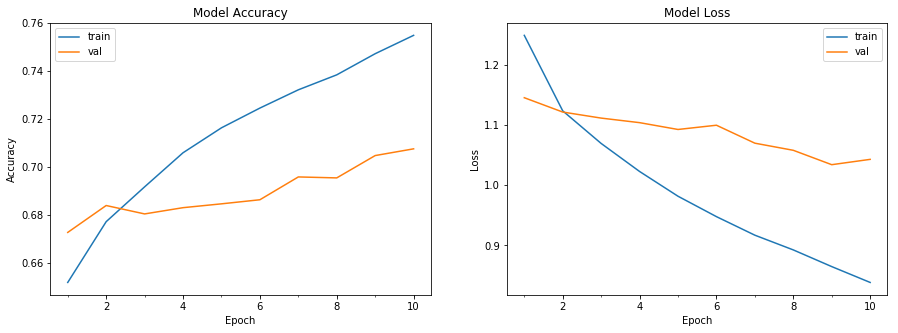

Accuracy on test data is: 70.75


In [28]:
# train the model
start = time.time()
# Train the model
model_info = model1.fit_generator(datagen2.flow(resnet_train_input, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features1.shape[0], nb_epoch = 10, 
                                 validation_data = (resnet_test_input, test_labels), verbose=1, 
                                 )
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(resnet_test_input, test_labels, model1))

# Gradcam of 50 miss classified images (not updated for cifar100)

In [0]:
# finding missclassifide images
y_preds = model1.predict(resnet_test_input)

In [29]:
print([layer.name for layer in model1.layers[0:] if "conv" in layer.name])

['conv0', 'stage1_unit1_conv1', 'stage1_unit1_conv2', 'stage1_unit2_conv1', 'stage1_unit2_conv2', 'stage2_unit1_conv1', 'stage2_unit1_conv2', 'stage2_unit2_conv1', 'stage2_unit2_conv2', 'stage3_unit1_conv1', 'stage3_unit1_conv2', 'stage3_unit2_conv1', 'stage3_unit2_conv2', 'stage4_unit1_conv1', 'stage4_unit1_conv2', 'stage4_unit2_conv1', 'stage4_unit2_conv2']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

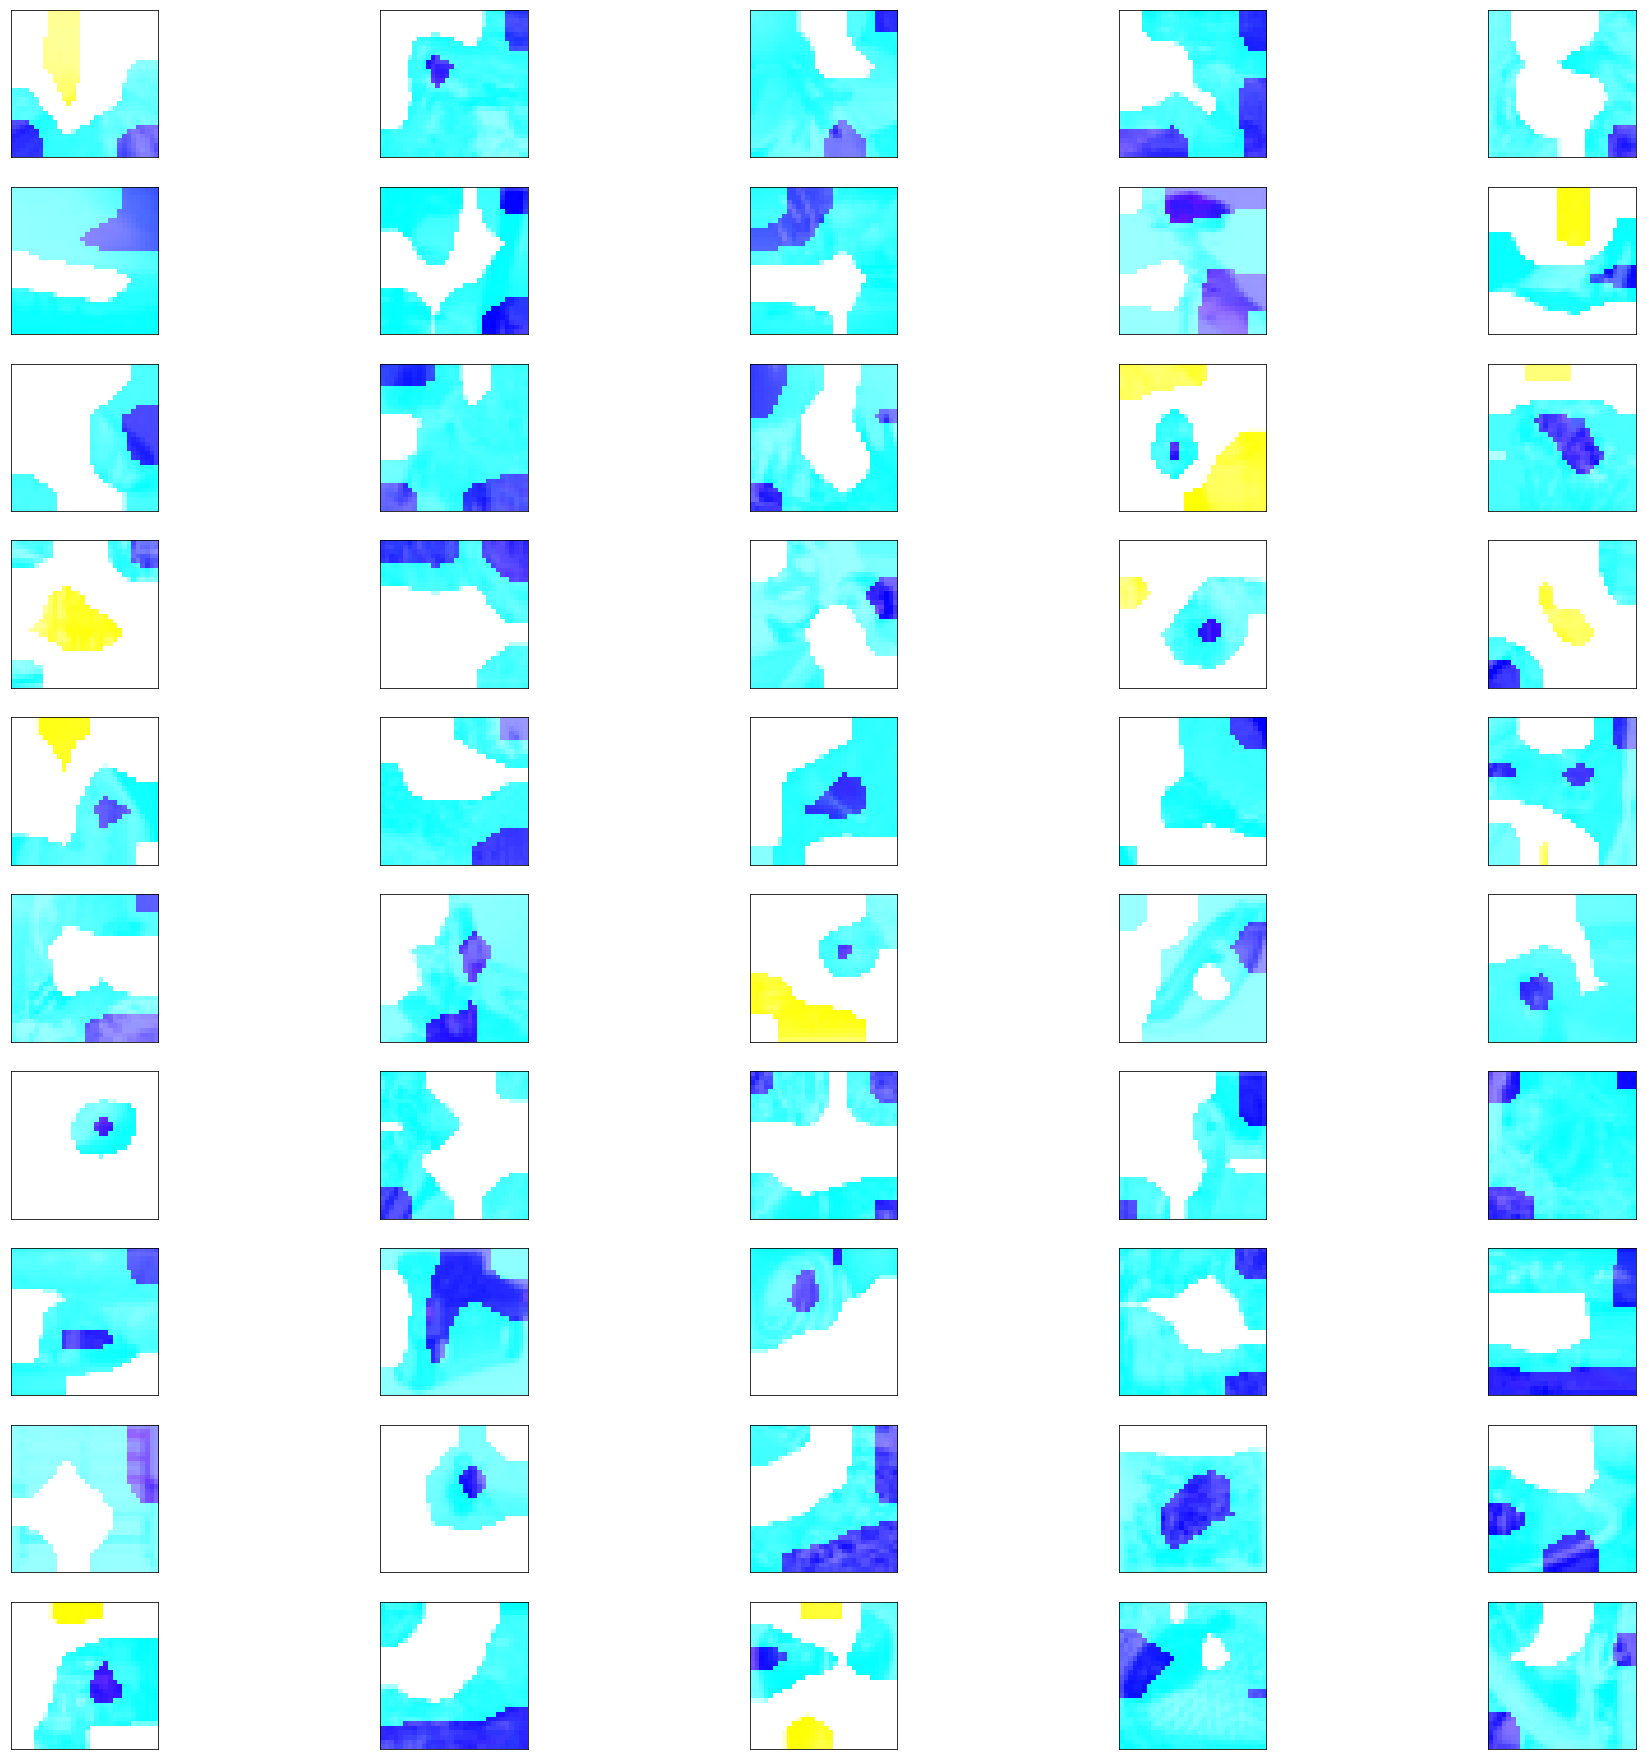

In [37]:
import cv2
from keras.preprocessing import image

#Showing gradcam of 25 miss classified images
class_names = ['airplane','automobile','bird','cat','deer', 'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(32,32))

test_l = np.argmax(test_labels, axis=1)
y_l = np.argmax(y_preds, axis=1)

#last convolution layer for current model is  
last_conv_layer = model1.get_layer("stage2_unit2_relu2") 

#counter of missclassified images
c = 0

for i in range(len (y_l)):
  if test_l[i] != y_l[i]:
    ax = fig.add_subplot(10, 5, 1+c, xticks=[], yticks=[])
    im = test_features[i]
    #titles = [("Actual:"+class_names[test_l[i]]+" Pred:"+class_names[y_l[i]]).replace(' ', ' ')]
    #ax.set_title(titles) #class_names[np.argmax(y_preds[img_num])])
    #plt.imshow(im)
    
    x = image.img_to_array(im)
    x = np.expand_dims(x, axis=0)
    class_output = model1.output[:, y_l[i]]
    
    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    #print (grads)
    iterate = K.function([model1.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for i in range(10):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    heatmap = cv2.resize(heatmap, (im.shape[1], im.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    superimposed_img = cv2.addWeighted(im, 0.6, heatmap, 0.4, 0, dtype = cv2.CV_32F)
    plt.imshow(superimposed_img)
    
    c=c+1
    if c==50:
      break
   
plt.show()

# cifar100 Data visualization

In [0]:
#class_names = ['airplane','automobile','bird','cat','deer', 'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    #ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()